In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt, gc, os
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import pickle

import warnings 
import xgboost as xgb

import time

warnings.filterwarnings("ignore")

In [2]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

train = pd.read_parquet("../data/train_woe_balanced.parquet")
train = train.fillna(-127)

In [3]:
train.drop('WOE_target',axis=1, inplace=True)

In [4]:
FEATURES = train.columns.to_list()
FEATURES.remove("target")
FEATURES = FEATURES[2:]

In [5]:
# Model Parameters

xgb_params = {
            'max_depth':4, 
            'learning_rate':0.05,
            'subsample': 0.8,
            'colsample_bytree':0.6,
            'eval_metric': 'logloss',
            #'updater':'refresh',
            #'process_type': 'update',
            #'refresh_leaf': 1,
            'objective':'binary:logistic',
            'tree_method':'gpu_hist',
            'predictor':'gpu_predictor',
            'random_state':42
            }
# xgb_params = {
#         'num_leaves': 10,
#         'max_bin': 127,
#         'min_data_in_leaf': 11,
#         'learning_rate': 0.035,
#         'bagging_fraction': 1.0, 
#         'bagging_freq': 5, 
#         'feature_fraction': 0.05,
#         'lambda_l1': 4.972,
#         'lambda_l2': 2.276,
#         'min_gain_to_split': 0.65,
#         'max_depth': 14,
#         'save_binary': True,
#         'seed': 1337,
#         'feature_fraction_seed': 1337,
#         'bagging_seed': 1337,
#         'drop_seed': 1337,
#         'data_random_seed': 1337,
#         'objective': 'binary',
#         'boosting_type': 'dart',
#         'verbose': 1,
#         'is_unbalance': True,
#         'boost_from_average': False,
#         'device': 'gpu',
#         'tree_method':'gpu_hist',
#         'predictor':'gpu_predictor',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
#         }



### Competition metric

In [6]:
#Competition metric
def amex_metric(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

### Model training

In [7]:
# Setting MLFlow
experiment_name = "XgBoost WOE balanced"
try:
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id 

In [8]:
importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0

skf = KFold(n_splits = 5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):

    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(42)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
        
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)

    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, 'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']

    batch_size = 200000
    model = None
    for start in range(0, len(X_train), batch_size):

        dtrain=xgb.DMatrix(X_train[start:start+batch_size], 
                            y_train[start:start+batch_size])
        d_test = xgb.DMatrix(X_valid[start:start+batch_size], 
                            y_valid[start:start+batch_size])

        model = xgb.train(
        {
        'max_depth':4, 
        'learning_rate':0.05,
        'subsample': 0.8,
        'colsample_bytree':0.6,
        'eval_metric': 'logloss',
        #'updater':'refresh',
        #'process_type': 'update',
        #'refresh_leaf': 1,
        'objective':'binary:logistic',
        'tree_method':'gpu_hist',
        'predictor':'gpu_predictor',
        'random_state':42
        },
        dtrain=dtrain,
        xgb_model=model,
        evals=[(dtrain, 'train'), (d_test, 'test')],
        num_boost_round= 9999,
        early_stopping_rounds = 100,
        verbose_eval= 100
                                    
        )
        del dtrain, d_test
        _ = gc.collect()
            

    model.save_model(f'../models/XGB_V_fold{fold}.xgb')
    mlflow.xgboost.log_model(model, "XGBClassifier")

    dd = model.get_score(importance_type='weight')
    df= pd.DataFrame({'feature':dd.keys(), f'importance_{fold}':dd.values()})
    importances.append(df)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    oof_preds = model.predict(dvalid)
    acc = amex_metric(y_valid.values, oof_preds)
    mlflow.log_metric("Kaggle Metric for XGBClassifier", acc)

    print("Kaggle Metric=", acc,'\n')

    df = train.loc[valid_idx, ['customer_ID', 'target']].copy()
    df['oof_pred']= oof_preds
    oof.append(df)

    del  X_train, y_train, dd, df
    del X_valid, y_valid, dvalid, model

print('#'*25)
oof = pd.concat(oof, axis=0, ignore_index=True).set_index('customer_ID')
acc= amex_metric(oof.target.values, oof.oof_pred.values)
print('OVERAL CV Kaggle Metric = ', acc)


#########################
### Fold 1
### Train size 4425160 Valid size 1106291
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66640	test-logloss:0.66623
[100]	train-logloss:0.27995	test-logloss:0.28575
[200]	train-logloss:0.26017	test-logloss:0.27488
[300]	train-logloss:0.24874	test-logloss:0.27078
[400]	train-logloss:0.23963	test-logloss:0.26812
[500]	train-logloss:0.23225	test-logloss:0.26637
[600]	train-logloss:0.22561	test-logloss:0.26510
[700]	train-logloss:0.21959	test-logloss:0.26408
[800]	train-logloss:0.21443	test-logloss:0.26325
[900]	train-logloss:0.20922	test-logloss:0.26249
[1000]	train-logloss:0.20441	test-logloss:0.26188
[1100]	train-logloss:0.19993	test-logloss:0.26136
[1200]	train-logloss:0.19555	test-logloss:0.26082
[1300]	train-logloss:0.19112	test-logloss:0.26035
[1400]	train-logloss:0.18723	test-logloss:0.26005
[1500]	train-logloss:0.18326	test-logloss:0.25971
[1600]	train-logloss:0.17924	test-logloss:0.25945
[1700]	train-logloss:

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

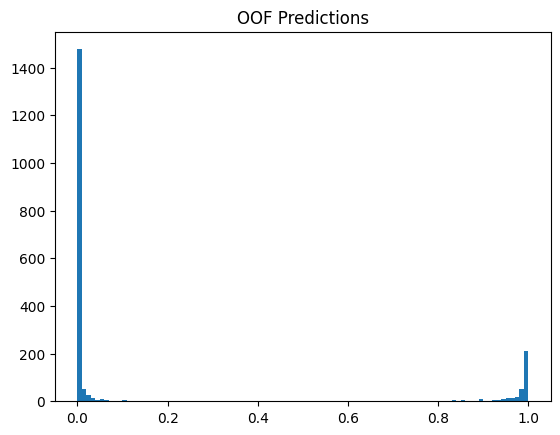

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
del oof_xgb, oof


## Feature Importance - !!!

In [ ]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

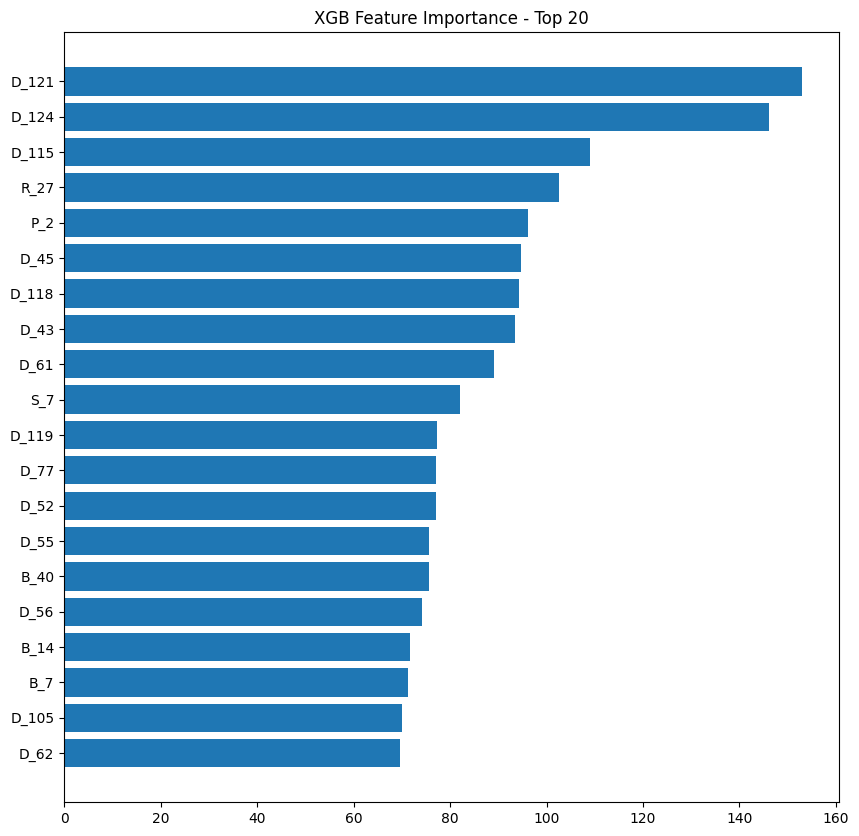

In [ ]:

NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()